# Analysis of Utility of IPUMS data.

In [3]:
import itertools

import matplotlib.pyplot as plt

from scipy.spatial import KDTree

from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant

from helper_functions import *

In [4]:
train_data = pd.read_csv("../Data/IPUMS/cleaned_ipums_data.csv")

In [5]:
sXs_mnl = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]
# ad_sXs_mnl = [pd.read_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]

sXs_cart = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv") for i in range(20)]
# ad_sXs_cart = [pd.read_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv") for i in range(20)]

sXs_mostly = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/mostly_" + str(i) + ".csv") for i in range(5)]

# NEED TO CHANGE THE RANGE VALUE FOR MOSTLY.AI

***

## Utility Measure 1 - pMSE Ratios

In [6]:
ratios_mnl = [pmse_ratio(train_data, Y) for Y in sXs_mnl]
print(np.mean(ratios_mnl))

# ratios_ad_mnl = [pmse_ratio(train_data, Y) for Y in ad_sXs_mnl]
# print(np.mean(ratios_ad_mnl))

ratios_cart = [pmse_ratio(train_data, Y) for Y in sXs_cart]
print(np.mean(ratios_cart))

# ratios_ad_cart = [pmse_ratio(train_data, Y) for Y in ad_sXs_cart]
# print(np.mean(ratios_ad_cart))

ratios_mostly = [pmse_ratio(train_data, Y) for Y in sXs_mostly]
np.mean(ratios_mostly)

1.013829040469967
0.9605744153405162


55.637618360922694

***

Save data for plotting in R.

In [5]:
pmse_results = pd.DataFrame({'Dataset': np.arange(1, len(ratios_mnl)+1),
                             'MNL': ratios_mnl,
                             # 'AD-MNL': ratios_ad_mnl,
                             'CART': ratios_cart,
                             # 'AD-CART': ratios_ad_cart,
                             'MOSTLY.AI': ratios_mostly})

pmse_results = pmse_results.melt(id_vars=["Dataset"], value_vars=["MNL", "AD-MNL", "CART", "AD-CART", "MOSTLY.AI"], var_name="Type")
pmse_results.to_csv('../Results/SK/pmse_metrics.csv', index=False)

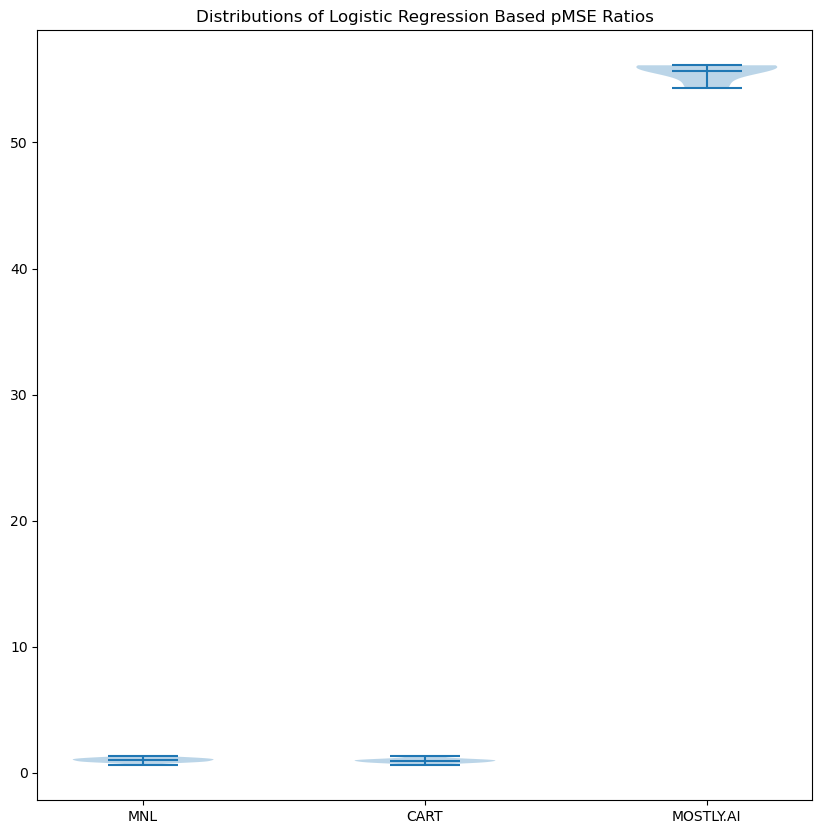

In [7]:
# Combine data
# plot_data = list([ratios_mnl, ratios_ad_mnl, ratios_cart, ratios_ad_cart, ratios_mostly])

plot_data = list([ratios_mnl, ratios_cart, ratios_mostly])

fig, ax = plt.subplots(figsize=(10,10))

# xticklabels = ["MNL", "AD-MNL", "CART", "AD-CART", "MOSTLY.AI"]
xticklabels = ["MNL", "CART", "MOSTLY.AI"]
# ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(xticklabels)

ax.violinplot(plot_data, showmeans=True)

plt.title("Distributions of Logistic Regression Based pMSE Ratios")

plt.show()

***

# Utility Metric 3: Analysis Specific Utility

###  * L1 distance between confidential and synthetic coefficient estimates
###  * Confidence interval ratio
###  * Sign, Significance, and Overlap (SSO)

Analysis specific utility.

Use logistic regression to predict COVID-19 deaths based on latitude and longitude, age, and sex.

Compute the model for the original data.

***

In [8]:
# def age_binary(data_set):
#     new_age = pd.Series(np.repeat(0, data_set.shape[0]))
#     new_age.loc[data_set.age==6] = 1
#     new_age.loc[data_set.age==7] = 1
#     new_age.loc[data_set.age==8] = 1
#     new_age.loc[data_set.age==9] = 1

#     data_set['age'] = new_age

#     return data_set

In [9]:
# age_binary(train_data)

***

In [10]:
def logit_param_fetcher(data, y, X):
    predictors = data.loc[:, X]
    predictors = add_constant(predictors)
    state_logit = Logit(endog=data.loc[:, y], exog=predictors)
    logit_results = state_logit.fit()
    return {"params": logit_results.params, 
            "l_var": np.diag(logit_results.cov_params()),
            "CI": logit_results.conf_int().reset_index(drop=True)}

Compute point estimate similarity (L1 distance between synthetic and original coefficients).

Do for one type of synthetic data sets for now.

# NEED TO WRITE UP THE SAME MODELS AS FROM THE JASA PAPER, REQUIRES RESCALING THE DATA SO THAT COEFFICIENTS AND L1 DISTANCES ARE ON THE SAME SCALE AS THE JASA PAPER FOR COMPARABILITY

Regress log annual earnings as a function of years_of_educ, non_white, and potential experience (up to third degree polynomial).

Do the above regression for males and females separately.

In [12]:
train_data

,incwage,years_of_educ,potential_experience,non_white,sex
0,-0.579435,1.109071,-0.039398,0,1
1,0.564281,0.724424,0.369388,0,0
2,-0.748874,-0.044869,-1.347515,0,0
3,-0.935257,-0.814163,-1.511030,0,0
4,-0.164308,-0.429516,1.186962,1,0
...,...,...,...,...,...
197751,-0.092296,1.109071,-0.448185,0,0
197752,-0.854774,1.109071,-0.611699,0,1
197753,0.521921,1.777461,0.063806,0,0
197754,-0.981853,0.724424,-0.448185,0,1


In [13]:
logit_train = logit_param_fetcher(data=train_data, y='non_white', X=['latitude', 'longitude', 'sex', 'age'])

Optimization terminated successfully.
         Current function value: 0.034034
         Iterations 11


***

In [14]:
logit_train

{'params': const       -7.808408
 latitude     0.123915
 longitude    0.281379
 sex          1.443160
 age          3.978782
 dtype: float64,
 'l_var': array([0.23088949, 0.04874646, 0.05248047, 0.10150451, 0.19031739]),
 'CI':           0         1
 0 -8.750189 -6.866626
 1 -0.308818  0.556647
 2 -0.167622  0.730379
 3  0.818720  2.067600
 4  3.123740  4.833824}

Of the original estimates, the only statistically significant coefficient is for the effect of `age` on `state`: older individuals have a higher probability of passing away from COVID-19. We are interested in whether the synthetic data estimates preserve this inference, while also preserving the conclusions that none of the other variables have a statistically significant effect.

We'll start with the L1 distances of the coefficients across the individual synthetic data sets.

Now, write a function that performs all previous steps given a synthetic data set and the train data set, returning a dataframe with the L1 differences in coefficients and a column that identifies the data type.

In [15]:
all_synthetic_data = [sXs_mnl, ad_sXs_mnl, sXs_cart, ad_sXs_cart, sXs_mostly]

In [16]:
for i in all_synthetic_data:
    for j in i:
        age_binary(j)

In [17]:
original_data = train_data
synthetic_datasets = ad_sXs_mnl
synthetic_data_type = 'MNL'
# copy synthetic datasets so they don't get edited on a global scope
all_synth = synthetic_datasets.copy()

In [18]:
# train a logistic regression model with state as the target and lat, long, sex, age, and sex*age as predictors
# function returns all parameter estimates, standard errors, and confidence intervals for the training data
logit_train = logit_param_fetcher(data=original_data, y='state', X=['latitude', 'longitude', 'sex', 'age'])

Optimization terminated successfully.
         Current function value: 0.034034
         Iterations 11


In [19]:
# estimate the same logistic regression model for all synthetic data sets and save params, standard errors, and CIs
logit_synth = [logit_param_fetcher(data=Y, y='state', X=['latitude', 'longitude', 'sex', 'age']) for Y in synthetic_datasets]

Optimization terminated successfully.
         Current function value: 0.044162
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032962
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.037631
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.037665
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033972
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032896
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.040800
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034907
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.035169
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Combine the above into the L1 function, make it so one variable could be used to do a join at the end.

In [29]:
def coef_L1_calc(original_data, synthetic_datasets, synthetic_data_type, target_variable, exog_variables, param_names):

    # copy synthetic datasets so they don't get edited on a global scope
    all_synth = synthetic_datasets.copy()

    # train a logistic regression model with state as the target and lat, long, sex, age, and sex*age as predictors
    # function returns all parameter estimates, standard errors, and confidence intervals for the training data
    logit_train = logit_param_fetcher(data=original_data, y=target_variable, X=exog_variables)

    # estimate the same logistic regression model for all synthetic data sets and save params, standard errors, and CIs
    logit_synth = [logit_param_fetcher(data=Y, y=target_variable, X=exog_variables) for Y in synthetic_datasets]

    # create a dataframe with the L1 distances for each coefficient in the columns, (rows are for each synthetic data set)
    # and a column identifying the data type
    l1_frame = pd.DataFrame()

    # calculate L1 distance
    for i in logit_synth:
        l1_frame = pd.concat([l1_frame, np.abs(i['params'] - logit_train['params'])], axis=1)

    l1_frame = l1_frame.T.reset_index(drop=True)
    l1_frame.columns = param_names
    l1_frame['Data Type'] = synthetic_data_type
    l1_frame['Measure'] = 'L1 Distance'

    # calculate CI ratio (width of synthetic / width of original)
    # calculate confidence interval ratios
    CI_ratio_frame = pd.DataFrame()
    for i in logit_synth:
        CI_ratio_frame = pd.concat([CI_ratio_frame, (i['CI'].iloc[:,1]-i['CI'].iloc[:,0]) / (logit_train['CI'].iloc[:,1]-logit_train['CI'].iloc[:,0])], axis=1)

    CI_ratio_frame = CI_ratio_frame.T.reset_index(drop=True)
    CI_ratio_frame.columns = param_names
    CI_ratio_frame['Data Type'] = synthetic_data_type
    CI_ratio_frame['Measure'] = 'CI Ratio'
    
    # calculate whether the signs of coefficients match
    sign_frame = pd.DataFrame()
    for i in logit_synth:
        sign_frame = pd.concat([sign_frame, abs(logit_train['params']) + abs(i['params']) == abs(logit_train['params'] + i['params'])], axis=1)

    sign_frame = sign_frame.T.reset_index(drop=True)
    sign_frame.columns = param_names
    sign_frame['Data Type'] = synthetic_data_type
    sign_frame['Measure'] = 'Sign Match'
    
    # check whether the statistical significance of the coefficients matches
    sig_frame = pd.DataFrame()
    orig_sig = pd.concat([logit_train['CI'].iloc[:,0] <= 0, 0 <= logit_train['CI'].iloc[:,1]], axis=1).all(axis=1)
    for i in logit_synth:
        sig_frame = pd.concat([sig_frame, pd.concat([i['CI'].iloc[:,0] <= 0, 0 <= i['CI'].iloc[:,1]], axis=1).all(axis=1).eq(orig_sig, axis=0)], axis=1)

    sig_frame = sig_frame.T.reset_index(drop=True)
    sig_frame.columns = param_names
    sig_frame['Data Type'] = synthetic_data_type
    sig_frame['Measure'] = 'Significance Match'
    
    # check whether confidence intervals overlap
    overlap_frame = pd.DataFrame()
    for synth in logit_synth:
        overlaps = []
        for i,j in synth['CI'].iterrows():
            i1 = pd.Interval(logit_train['CI'].iloc[i,0], logit_train['CI'].iloc[i,1], closed='both')
            i2 = pd.Interval(j[0], j[1], closed='both')
            overlaps.append(i1.overlaps(i2))
        overlap_frame = pd.concat([overlap_frame, pd.Series(overlaps)], axis=1)

    overlap_frame = overlap_frame.T.reset_index(drop=True)
    overlap_frame.columns = param_names
    overlap_frame['Data Type'] = synthetic_data_type
    overlap_frame['Measure'] = 'CI Overlap'

    return pd.concat([l1_frame, CI_ratio_frame, sign_frame, sig_frame, overlap_frame], axis=0)

In [30]:
synthetic_data_types = ['MNL', 'AD - MNL', 'CART', 'AD - CART', 'MOSTLY.AI']

In [31]:
all_l1_results = pd.DataFrame()

for i, j in enumerate(all_synthetic_data):
    all_l1_results = pd.concat([all_l1_results, coef_L1_calc(original_data=train_data, synthetic_datasets=j, synthetic_data_type=synthetic_data_types[i],
                                                             target_variable='state', exog_variables=['latitude', 'longitude', 'sex', 'age'],
                                                             param_names=['Intercept', 'Latitude', 'Longitude', 'Sex', 'Age']).reset_index(drop=True)], axis=0)

Optimization terminated successfully.
         Current function value: 0.034034
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.043799
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032910
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.037329
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.037481
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033512
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032834
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.040382
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034973
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

In [32]:
all_l1_results

,Intercept,Latitude,Longitude,Sex,Age,Data Type,Measure
0,1.596675,0.180348,0.481223,0.760346,1.065296,MNL,L1 Distance
1,1.325679,0.304107,0.560194,0.900817,1.157585,MNL,L1 Distance
2,1.181997,0.230062,0.424065,0.762374,0.792058,MNL,L1 Distance
3,1.309940,0.328886,0.155078,1.050510,0.818470,MNL,L1 Distance
4,0.782288,0.001727,0.393069,0.228788,0.885278,MNL,L1 Distance
...,...,...,...,...,...,...,...
95,1.000000,1.000000,1.000000,1.000000,1.000000,MOSTLY.AI,CI Overlap
96,1.000000,1.000000,1.000000,1.000000,1.000000,MOSTLY.AI,CI Overlap
97,1.000000,1.000000,1.000000,1.000000,1.000000,MOSTLY.AI,CI Overlap
98,1.000000,1.000000,1.000000,1.000000,1.000000,MOSTLY.AI,CI Overlap


In [33]:
all_l1_results = all_l1_results.melt(id_vars=["Data Type", "Measure"], value_vars=['Intercept', 'Latitude', 'Longitude', 'Sex', 'Age'], var_name="Variable")

In [34]:
all_l1_results

,Data Type,Measure,Variable,value
0,MNL,L1 Distance,Intercept,1.596675
1,MNL,L1 Distance,Intercept,1.325679
2,MNL,L1 Distance,Intercept,1.181997
3,MNL,L1 Distance,Intercept,1.309940
4,MNL,L1 Distance,Intercept,0.782288
...,...,...,...,...
2495,MOSTLY.AI,CI Overlap,Age,1.000000
2496,MOSTLY.AI,CI Overlap,Age,1.000000
2497,MOSTLY.AI,CI Overlap,Age,1.000000
2498,MOSTLY.AI,CI Overlap,Age,1.000000


Save data for analysis and plotting in R.

In [35]:
all_l1_results.to_csv('../Results/SK/analysis_specific.csv', index=False)

***